# NHANES 2013-14

The National Health and Nutrition Examination Survey (NHANES) is a program of studies designed to assess the health and nutritional status of adults and children in the United States. The survey is unique in that it combines interviews and physical examinations. 

The original data is accessible from: https://wwwn.cdc.gov/nchs/nhanes/Default.aspx and converted from sas to csv here: https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey/data  

You can find the complete information about the variables and the original questions asked in the data's Codebook and Questionnaire here: https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2013. Or find the specific links for each data file in the project description pdf file. 

The six data files can be merged together using the variable SEQN (respondent’s unique sequence number). 


In [1]:
# import packages you need
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.tree as tree     
import sklearn.ensemble as ens
import sklearn.neighbors as nei
import statsmodels.formula.api as smf

In [2]:
#read in the data
labs = pd.read_csv('labs.csv')
exam = pd.read_csv('examination.csv')
demo = pd.read_csv('demographic.csv')
ques = pd.read_csv('questionnaire.csv')
meds = pd.read_csv('medications.csv', encoding='latin-1')



In [3]:
#check one, for example:
meds.head()

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
0,73557,1,99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,73557,1,INSULIN,d00262,2.0,1460.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,2.0
2,73558,1,GABAPENTIN,d03182,1.0,243.0,G25.81,NaN,NaN,Restless legs syndrome,NaN,NaN,4.0
3,73558,1,INSULIN GLARGINE,d04538,1.0,365.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,4.0
4,73558,1,OLMESARTAN,d04801,1.0,14.0,E11.2,NaN,NaN,Type 2 diabetes mellitus with kidney complicat...,NaN,NaN,4.0


In [4]:
#merge those files you need, based on the patients ID (SEQN)
exam.drop(['SEQN'], axis = 1, inplace=True)
demo.drop(['SEQN'], axis = 1, inplace=True)
ques.drop(['SEQN'], axis = 1, inplace=True)
meds.drop(['SEQN'], axis = 1, inplace=True)
labs.drop(['SEQN'], axis = 1, inplace=True)


df = pd.concat([labs, exam], axis=1, join='inner')
df = pd.concat([df, demo], axis=1, join='inner')
df = pd.concat([df, ques], axis=1, join='inner')
df = pd.concat([df, meds], axis=1, join='inner')
df = pd.concat([df, labs], axis=1, join='inner')

In [5]:
# check the dimention of the data- number of rows and columns
df.shape

(9813, 2079)

In [6]:
#see the first 5 rows
df.head()

,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,LBDSALSI,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
0,4.3,4.3,39.0,3447.6,11.03,NaN,NaN,NaN,4.1,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7
1,153.0,153.0,50.0,4420.0,306.00,NaN,NaN,NaN,4.7,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2
2,11.9,11.9,113.0,9989.2,10.53,142196.890197,57.0,0.57,3.7,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2
3,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,NaN,...,0.062,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN
4,255.0,255.0,147.0,12994.8,173.47,142266.006548,92.0,0.92,4.3,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1


In [7]:
#change the variable/column names to meaningful words for easier handling
#for example:

df = df.rename(columns = {
                          'RIAGENDR' : 'gender',
                          'INDFMPIR' : 'family_income',
                          'BMXBMI' : 'BMI',
                          'DUQ240' : 'drug_use',
                          'ALQ101' : 'drink_alcohol',
                          'MCQ160C' : 'coronary_heart_disease',
                          'RIDAGEYR': 'age', 
                          'RIDRETH3': 'race',
                          'DMDEDUC2': 'education_over20',
                          "DMDFMSIZ" : "family_size",
                          "WHD020": "weight",
                          "WHD110": "weight_10_years_ago"
                         })



#to see what each number means under each code:
#Demographic https://wwwn.cdc.gov/nchs/nhanes/2013-2014/demo_h.htm#Codebook
#Drug use https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DUQ_J.htm#Codebook
#Heart https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_MCQ.htm#Codebook


In [8]:
#depending on your study questions, choose the columns that are needed and make a smaller dataset to use.
#for example
subset_df = df[['coronary_heart_disease','gender','family_income','BMI','drink_alcohol', "age","race","family_size",'education_over20',"weight","weight_10_years_ago"]]
subset_df.describe()


,coronary_heart_disease,gender,family_income,BMI,drink_alcohol,age,race,family_size,education_over20,weight,weight_10_years_ago
count,5561.000000,9813.000000,9051.000000,9055.000000,5223.000000,9813.000000,9813.000000,9813.000000,5561.000000,6196.000000,4036.000000
mean,1.982377,1.509426,2.253101,25.678244,1.312464,31.466320,3.291246,3.730052,3.518612,255.694480,413.440287
std,0.445657,0.499937,1.635458,7.955137,0.548327,24.413015,1.614486,1.774712,1.232965,872.943399,1511.368399
min,1.000000,1.000000,0.000000,12.100000,1.000000,0.000000,1.000000,1.000000,1.000000,75.000000,75.000000
25%,2.000000,1.000000,0.870000,19.700000,1.000000,10.000000,2.000000,2.000000,3.000000,143.000000,140.000000
50%,2.000000,2.000000,1.710000,24.700000,1.000000,26.000000,3.000000,4.000000,4.000000,170.000000,165.000000
75%,2.000000,2.000000,3.610000,30.200000,2.000000,52.000000,4.000000,5.000000,5.000000,200.000000,198.000000
max,9.000000,2.000000,5.000000,82.900000,9.000000,80.000000,7.000000,7.000000,9.000000,9999.000000,9999.000000


You can save the subset in a file in the directory as a csv file. Then remove the original dataset and work with the smaller version in a new notebook for convenience.

### should we drop these "missing" data?

Different code has been used to show missingness in the data. We change them to NA:

In [9]:
subset_df = subset_df.astype(float)
subset_df.replace([7, 77, 777, 7777, 9, 99, 999, 9999], np.nan, inplace=True)

# there is a waring about replacing some values in the dataset


In [10]:
#check the number of missing values and decide what to do with them, maybe removing the rows or not using a variable with many NAs
np.sum(subset_df.isnull())

coronary_heart_disease    4270
gender                       0
family_income              762
BMI                        758
drink_alcohol             4598
age                        469
race                       454
family_size                786
education_over20          4258
weight                    3673
weight_10_years_ago       5879
dtype: int64

In [11]:
subset_df = subset_df.dropna()
subset_df.shape

(2737, 11)

__Note__:

- Check "type" of the variables. If a variable is Categorical (0/1, 1/2, Yes/No) make sure to change its type to category and give meaningful labels to categories. 
- When fitting a model make sure that the type of the variables are appropriate, for example, if the response is binary, it has to take values 0 and 1 and the proper linear model would be a logictic regression.

In [12]:
# Save the DataFrame as a CSV file
subset_df.to_csv('subset_df.csv', index=False)
subset_df = pd.read_csv('subset_df.csv')

### Change each type to category and labeling 

In [13]:
subset_df['gender'] = subset_df['gender'].astype('category')
subset_df['gender'] = subset_df['gender'].cat.rename_categories({1: 'Male', 2: 'Female'})
subset_df['gender'].value_counts()

# Check unique values
print(subset_df['gender'].unique())

['Male', 'Female']
Categories (2, object): ['Male', 'Female']


In [14]:
subset_df['coronary_heart_disease'] = subset_df['coronary_heart_disease'].astype('category')
subset_df['coronary_heart_disease'] = subset_df['coronary_heart_disease'].cat.rename_categories({1: 'Yes', 2: 'No'})

subset_df['coronary_heart_disease'].value_counts()

No     2582
Yes     155
Name: coronary_heart_disease, dtype: int64

In [15]:
#out of 4270, 162 has heart disease

In [16]:
subset_df['race'] = subset_df['race'].astype('category')
subset_df['race'] = subset_df['race'].cat.rename_categories({1: 'MexicanAmerican', 2: 'OtherHispanic', 3: "White", 4: "Black", 6:"Asian"})
subset_df['race'].value_counts()

White              1327
Black               568
MexicanAmerican     328
Asian               287
OtherHispanic       227
Name: race, dtype: int64

In [17]:
subset_df['drink_alcohol'] = subset_df['drink_alcohol'].astype('category')
subset_df['drink_alcohol'] = subset_df['drink_alcohol'].cat.rename_categories({1: 'Yes', 2: 'No'})
subset_df['drink_alcohol'].value_counts()

Yes    1971
No      766
Name: drink_alcohol, dtype: int64

In [18]:
print(df['age'].describe())

count    9813.000000
mean       31.466320
std        24.413015
min         0.000000
25%        10.000000
50%        26.000000
75%        52.000000
max        80.000000
Name: age, dtype: float64


In [19]:
subset_df.dtypes

coronary_heart_disease    category
gender                    category
family_income              float64
BMI                        float64
drink_alcohol             category
age                        float64
race                      category
family_size                float64
education_over20           float64
weight                     float64
weight_10_years_ago        float64
dtype: object

In [20]:
subset_df.value_counts(['coronary_heart_disease', 'drink_alcohol']).reset_index().rename(columns={0:'count'})

,coronary_heart_disease,drink_alcohol,count
0,No,Yes,1856
1,No,No,726
2,Yes,Yes,115
3,Yes,No,40


In [21]:
#People who drink alcohol 4.3% has heart disease; people who don't drink alcohol 4.0% has heart disease.

# People who have heart disease, 74% drinks; people who don't have heart disease, 72% drinks

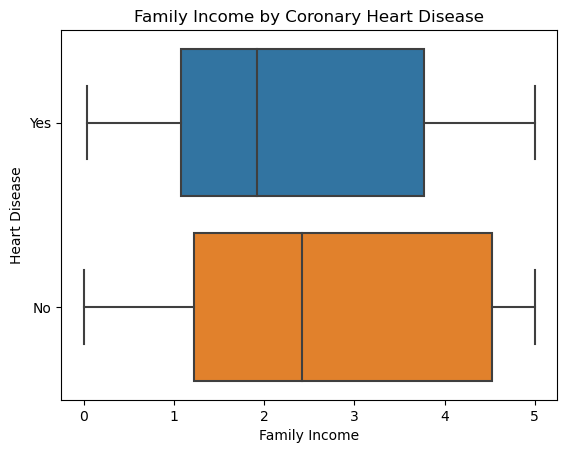

In [23]:
sns.boxplot(data=subset_df, x='family_income', y='coronary_heart_disease')
plt.title('Family Income by Coronary Heart Disease')
plt.xlabel('Family Income')
plt.ylabel('Heart Disease')
plt.show()

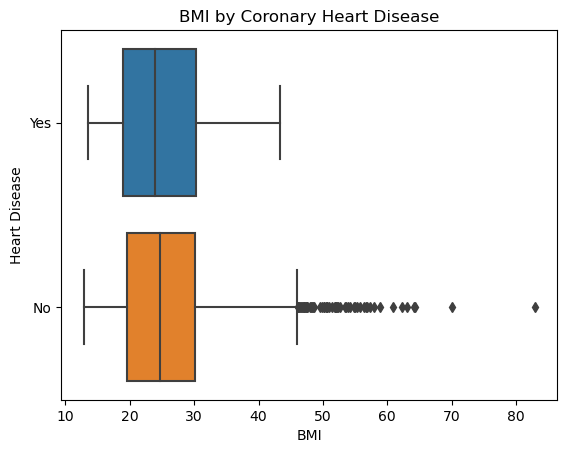

In [24]:
sns.boxplot(data=subset_df, x='BMI', y='coronary_heart_disease')
plt.title('BMI by Coronary Heart Disease')
plt.xlabel('BMI')
plt.ylabel('Heart Disease')
plt.show()

In [25]:
subset_df['weight_change'] = subset_df['weight'] - subset_df['weight_10_years_ago']



print(subset_df.describe())

       family_income          BMI          age  family_size  education_over20  \
count    2737.000000  2737.000000  2737.000000  2737.000000       2737.000000   
mean        2.709273    25.657106    57.345999     2.709536          3.591889   
std         1.646832     8.156298    12.980492     1.440090          1.211413   
min         0.000000    12.900000    36.000000     1.000000          1.000000   
25%         1.210000    19.600000    46.000000     2.000000          3.000000   
50%         2.400000    24.700000    57.000000     2.000000          4.000000   
75%         4.510000    30.300000    67.000000     4.000000          5.000000   
max         5.000000    82.900000    80.000000     6.000000          5.000000   

            weight  weight_10_years_ago  weight_change  
count  2737.000000          2737.000000    2737.000000  
mean    180.123128           173.189258       6.933869  
std      45.972729            46.363891      29.318945  
min      75.000000            75.000000   

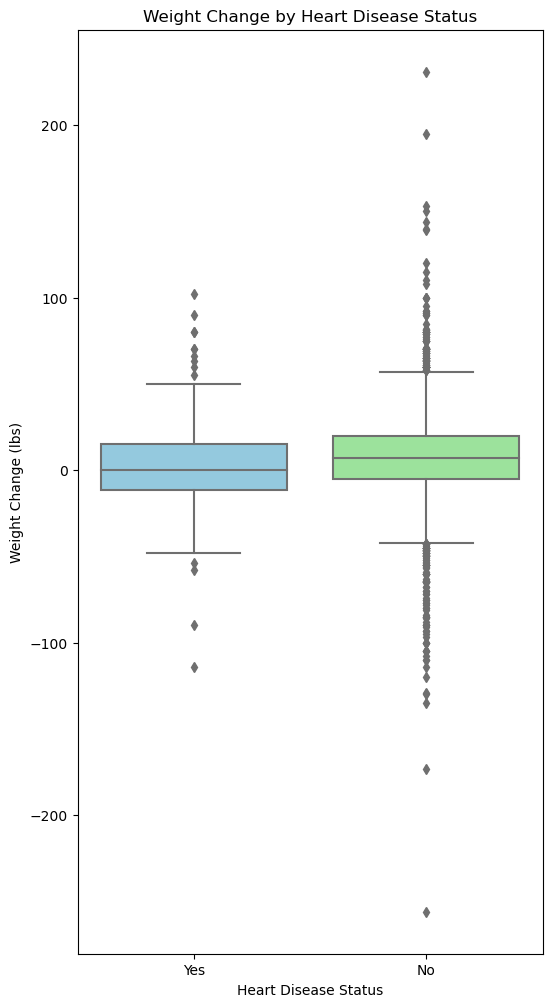

In [26]:
# Create subplots
fig, axs = plt.subplots(figsize=(6, 12), sharey=True)

sns.boxplot(data=subset_df, x='coronary_heart_disease', y='weight_change', palette={'Yes': 'skyblue', 'No': 'lightgreen'})

# Add titles and labels
plt.title('Weight Change by Heart Disease Status')
plt.xlabel('Heart Disease Status')
plt.ylabel('Weight Change (lbs)')

# Show the plot
plt.show()

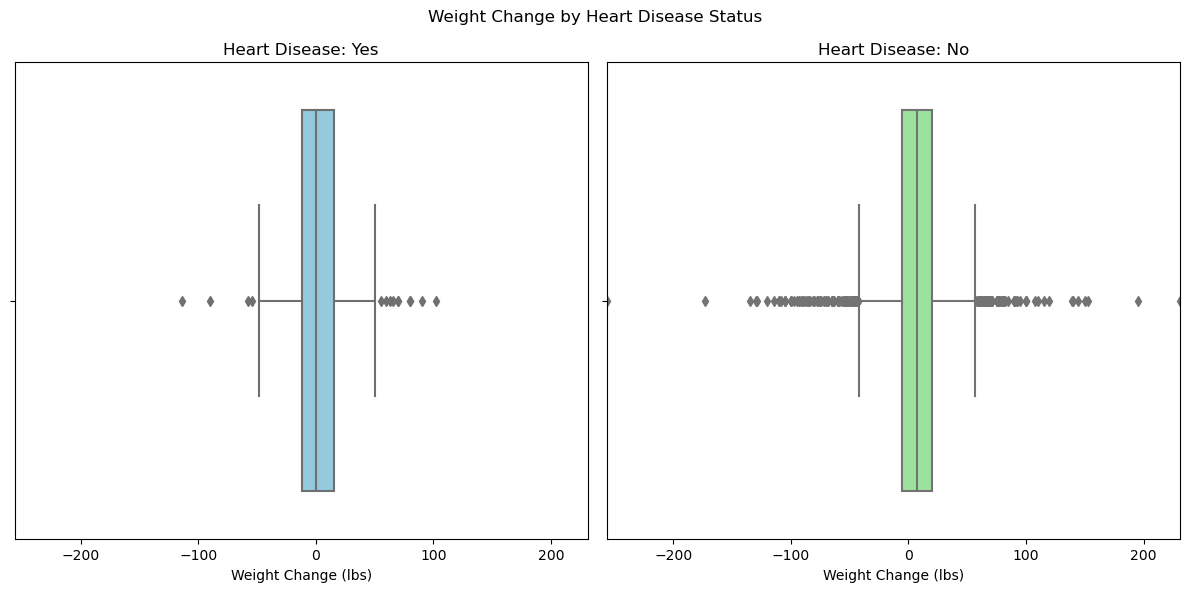

In [27]:
heart_disease_yes = subset_df[subset_df['coronary_heart_disease'] == 'Yes']
heart_disease_no = subset_df[subset_df['coronary_heart_disease'] == 'No']

# Determine the common x-axis range
min_x = min(heart_disease_yes['weight_change'].min(), heart_disease_no['weight_change'].min())
max_x = max(heart_disease_yes['weight_change'].max(), heart_disease_no['weight_change'].max())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Box plot for "Yes"
sns.boxplot(data=heart_disease_yes, x='weight_change', ax=axs[0], color='skyblue')
axs[0].set_title('Heart Disease: Yes')
axs[0].set_xlabel('Weight Change (lbs)')
axs[0].set_ylabel('')
axs[0].set_xlim(min_x, max_x)  # Set common x-axis limits

# Box plot for "No"
sns.boxplot(data=heart_disease_no, x='weight_change', ax=axs[1], color='lightgreen')
axs[1].set_title('Heart Disease: No')
axs[1].set_xlabel('Weight Change (lbs)')
axs[1].set_ylabel('')
axs[1].set_xlim(min_x, max_x)  # Set common x-axis limits

# Add overall title and show plot
plt.suptitle('Weight Change by Heart Disease Status')
plt.tight_layout()
plt.show()

In [28]:
subset_df.value_counts(['coronary_heart_disease', 'gender']).reset_index().rename(columns={0:'count'})

,coronary_heart_disease,gender,count
0,No,Female,1368
1,No,Male,1214
2,Yes,Male,98
3,Yes,Female,57


In [29]:
# Calculate summary statistics for each subset
summary_yes = heart_disease_yes['weight_change'].describe()
summary_no = heart_disease_no['weight_change'].describe()

# Display the summary
print("Summary for individuals with heart disease (Yes):")
print(summary_yes)
print("\nSummary for individuals without heart disease (No):")
print(summary_no)

Summary for individuals with heart disease (Yes):
count    155.000000
mean       3.690323
std       30.114191
min     -114.000000
25%      -11.500000
50%        0.000000
75%       15.000000
max      102.000000
Name: weight_change, dtype: float64

Summary for individuals without heart disease (No):
count    2582.000000
mean        7.128582
std        29.265060
min      -256.000000
25%        -5.000000
50%         7.000000
75%        20.000000
max       231.000000
Name: weight_change, dtype: float64


# Machine learning (not working atm)

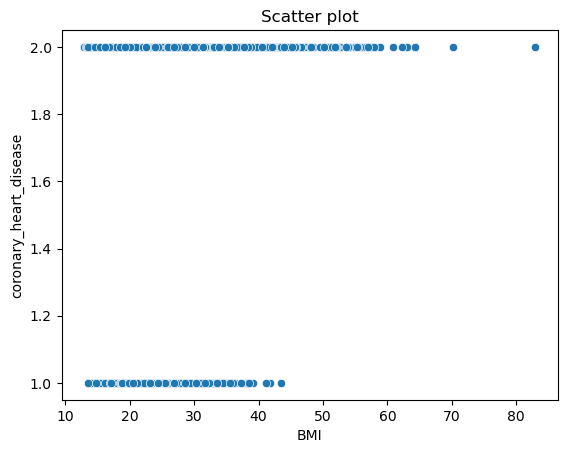

In [30]:
# reading the training and testing simulated data 
train_data = pd.read_csv('subset_df.csv')
test_data = pd.read_csv('subset_df.csv')

# Creating the train and test based on features and response separation as new subsets
X_train = train_data[['gender','family_income','BMI','drink_alcohol', "age","race","family_size",'education_over20', "weight_10_years_ago", "weight"]]
y_train = train_data['coronary_heart_disease']
X_test = test_data[['gender','family_income','BMI','drink_alcohol', "age","race","family_size",'education_over20',"weight_10_years_ago", "weight"]]
y_test = test_data['coronary_heart_disease']

# Creating the scatterplot of the variables xs and ys, also colored based on yc class
sns.scatterplot(data=train_data, x='BMI', y='coronary_heart_disease')
plt.title('Scatter plot')
plt.show()

Decision tree

In [31]:
print(X_train.isnull().sum())

gender                 0
family_income          0
BMI                    0
drink_alcohol          0
age                    0
race                   0
family_size            0
education_over20       0
weight_10_years_ago    0
weight                 0
dtype: int64


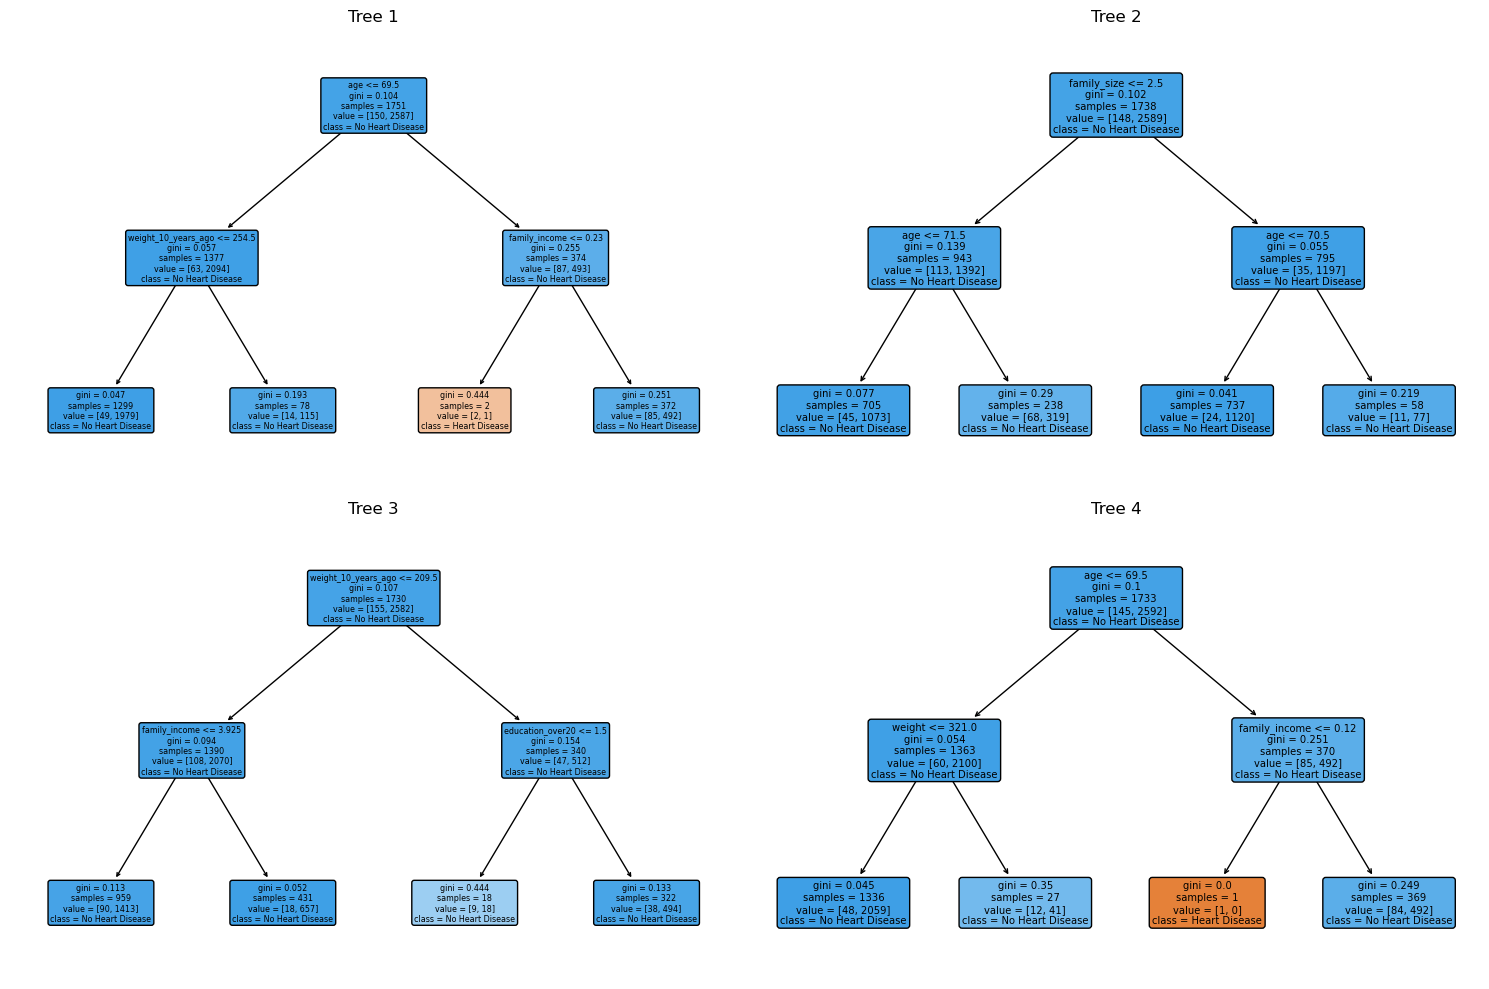

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

random_state = 42

# Initialize a Random Forest classifier
rf_class = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=random_state)  # 10 trees, max depth of 2

# Train the Random Forest on the training data
rf_class.fit(X_train, y_train)

# Visualize the first few trees in the random forest
num_trees_to_plot = 4  # Number of trees to visualize
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Create a grid for plots

for i in range(num_trees_to_plot):
    row = i // 2  # Determine the row (0 or 1)
    col = i % 2   # Determine the column (0 or 1)
    plot_tree(
        rf_class.estimators_[i], 
        feature_names=X_train.columns,  # Use feature names
        class_names=['Heart Disease', 'No Heart Disease'],  # Optional: Class labels
        filled=True,  # Add color for better readability
        rounded=True,  # Rounded boxes
        ax=axs[row, col]  # Plot in the specific subplot
    )
    axs[row, col].set_title(f'Tree {i + 1}')  # Add title for each tree

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
# decision tree and random forests are not good methods for prediction as the leafs predicting positive in heart diease only have a sample size of 1-3

In [ ]:
#Test KNN


# Initialize a k-nearest neighbors classifier with k=3 neighbors and Euclidean distance metric
knn_class = nei.KNeighborsClassifier(n_neighbors = 3, metric='euclidean')

# Fit the KNN classifier on the training data
knn_class.fit(X_train, y_train)

# Use the trained classifier to predict the class for a new data point
y_predict = knn_class.predict(X_test)

print(y_predict)

In [ ]:
# Generating the Confusion matrix
print('Confusion matrix: ',skl.metrics.confusion_matrix(y_test,y_predict))

# Calculating the Precision value
print('Precision: ',skl.metrics.precision_score(y_test,y_predict))

# Calculating the Recall value
print('Recall: ',skl.metrics.recall_score(y_test,y_predict))

# Calculating the Balanced accuracy
print('Balanced accuracy: ',skl.metrics.balanced_accuracy_score(y_test,y_predict))

# Calculating the F1 score
print('F1 score: ',skl.metrics.f1_score(y_true=y_test,y_pred=y_predict))

Out of all the cases where the model predicted "heart disease," only 21.9% were correct. 

Out of all the actual "heart disease" cases, the model caught 72.3%.

# Test logistic regression

In [ ]:
subset2_df = df[['coronary_heart_disease', 'gender', 'drink_alcohol']].copy()
subset2_df= subset2_df.replace({2: 0})

# Replace unwanted values with NaN
subset2_df = subset2_df.replace([7, 77, 777, 7777, 9, 99, 999, 9999], np.nan)

# Count the number of null values (if needed)
print(np.sum(subset2_df.isnull()))

# Drop rows with missing values
subset2_df = subset2_df.dropna()

# Check summary statistics
print(subset2_df.describe())

#1 means yes, 0 means no

In [ ]:
# Fitting a logistic regression model
                    
log_reg = smf.logit("coronary_heart_disease ~ gender", data=subset2_df).fit()
log_reg.summary()

In [ ]:
# calculating Odds Ratios and their confidence intervals
coefficients = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
odds_ratios = np.exp(coefficients)
print(odds_ratios)

In [ ]:
#model assessment
actual_response = subset2_df["coronary_heart_disease"]
predicted_response = np.round(log_reg.predict()) # <=0.5 -> 0
outcomes = pd.DataFrame({"actual_response": actual_response, "predicted_response": predicted_response})
print(outcomes.value_counts(sort=False))

In [ ]:
#seem pretty useless as all the predictions are 0